In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef
from sklearn.feature_extraction.text import CountVectorizer
import spacy

In [69]:
nlp = spacy.load("en_core_web_sm")


In [70]:
df = pd.read_csv('demo_data.csv')

In [71]:
bad_domains = ['obisims.com', 'janfab.com','esterace.com','konetas.com','barakal.com','rogtat.com','coloruz.com','obisims.com','esterace.com','ploncy.com','daypey.com','apifan.com','amxyy.com','starmail.net','hapied.com','inpsur.com','kwalah.com','avashost.com','ndiety.com','polatrix.com','hellomailo.net','albarulo.com','in.ua','chaladas.com','maillsk.com','superexemail.ru','tetraheemail.ru','oxidamail.ru','oonmail.com','mailkv.com','iteradev.com','acpeak.com','givehit.com','brinkc.com','maillv.com','segichen.com','luvnish.com','biowey.com','rowdydow.com','foraro.com','eixdeal.com','biscoine.com','alientex.com','mvpalace.com','almaxen.com','orsbap.com','maxturns.com','qodiq.com','fuzitea.com','leacore.com','modotso.com','vasomly.com','reebsd.com','tiervio.com','sablecc.com','padvn.com','ikangou.com','apn7.com','furnato.com','cartep.com','atebin.com','bsidesmn.com','calunia.com','carspure.com','bacaki.com'] 

In [72]:
def extract_username(email):
    return email.split('@')[0]

In [73]:
def extract_domain(email):
    return email.split('@')[-1]

In [74]:
def is_bad_domain(email):
    domain = extract_domain(email)
    return 1 if domain in bad_domains else 0

In [75]:
df.head(20)

,email,label
0,victor.lamadrid@enron.com,1
1,mary.cook@enron.com,1
2,sara.shackleton@enron.com,1
3,michelle.nelson@enron.com,1
4,total@shagmail.com,1
5,buy.com@enews.buy.com,1
6,lorna.brennan@enron.com,0
7,cs1@bmgmusicservice.com,1
8,m..love@enron.com,1
9,cgiron@mindspring.com,1


In [76]:
def extract_features(email):
    username = email.split('@')[0]
    length_of_username = len(username)
    num_special_chars = sum(not char.isalnum() for char in username)
    digits_to_letters_ratio = sum(char.isdigit() for char in username) / (sum(char.isalpha() for char in username) + 1)
    consecutive_chars = sum(username[i] == username[i+1] for i in range(len(username)-1))
    return [length_of_username, num_special_chars, digits_to_letters_ratio, consecutive_chars]

In [77]:
def contains_person_name(username):
    doc = nlp(username)
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            return 1
    return 0

In [78]:
df.head()

,email,label
0,victor.lamadrid@enron.com,1
1,mary.cook@enron.com,1
2,sara.shackleton@enron.com,1
3,michelle.nelson@enron.com,1
4,total@shagmail.com,1


In [79]:
basic_features = np.array([extract_features(email) for email in df['email']])
df['has_person_name'] = df['email'].apply(lambda x: contains_person_name(extract_username(x)))



In [80]:
features_with_ner = np.hstack((basic_features, df['has_person_name'].values.reshape(-1, 1)))

In [81]:
usernames = df['email'].apply(extract_username)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2))
X_ngrams = vectorizer.fit_transform(usernames)

In [82]:
X_combined = np.hstack((features_with_ner, X_ngrams.toarray()))

In [83]:
df['untrustworthy_domain'] = df['email'].apply(is_bad_domain)
X_final = np.hstack((X_combined, df['untrustworthy_domain'].values.reshape(-1, 1)))

In [84]:
y = df['label'].values

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [86]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [87]:
def predict_with_domain_check(X, model):
    predictions = []
    for features in X:
        if features[-1] == 1:
            predictions.append(0)
        else:
            prediction = model.predict(features.reshape(1, -1))
            predictions.append(prediction[0])
    return predictions

In [88]:
df_unlabeled = pd.read_csv('emails_filtered.csv')

In [89]:
basic_features_unlabeled = np.array([extract_features(email) for email in df_unlabeled['email_ids']])
df_unlabeled['has_person_name'] = df_unlabeled['email_ids'].apply(lambda x: contains_person_name(extract_username(x)))

In [90]:
features_with_ner_unlabeled = np.hstack((basic_features_unlabeled, df_unlabeled['has_person_name'].values.reshape(-1, 1)))

In [91]:
usernames_unlabeled = df_unlabeled['email_ids'].apply(extract_username)

In [92]:
X_ngrams_unlabeled = vectorizer.transform(usernames_unlabeled)

In [93]:
X_combined_unlabeled = np.hstack((features_with_ner_unlabeled, X_ngrams_unlabeled.toarray()))

In [94]:
df_unlabeled['untrustworthy_domain'] = df_unlabeled['email_ids'].apply(is_bad_domain)
X_final_unlabeled = np.hstack((X_combined_unlabeled, df_unlabeled['untrustworthy_domain'].values.reshape(-1, 1)))

In [95]:
y_pred_unlabeled = predict_with_domain_check(X_final_unlabeled, model)

In [96]:
df_unlabeled['Predicted_Label'] = y_pred_unlabeled

In [97]:
print(df_unlabeled)

                          email_ids  has_person_name  untrustworthy_domain  \
0         blessonbabu6446@gmail.com                0                     0   
1               rakr41092@gmail.com                0                     0   
2              juan@betterect.co.za                0                     0   
3      daniel.skarhammar@fmtmark.se                1                     0   
4                      p1304.gurdsi                0                     0   
...                             ...              ...                   ...   
50364    devishikanak.com@gmail.com                0                     0   
50365        nguyen@henne-walter.de                0                     0   
50366        kor7979tmdah@gmail.com                0                     0   
50367          dalcom.zzi@gmail.com                0                     0   
50368              418863555@qq.com                0                     0   

       Predicted_Label  
0                    0  
1            

In [341]:
y_pred = predict_with_domain_check(X_test, model)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9924160346695557


In [342]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9924160346695557


In [343]:
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")


Recall: 0.9826086956521739


In [344]:
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

F1 Score: 0.9699570815450643


In [345]:
y_prob = model.predict_proba(X_test)[:, 1] 
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.998331898407232


In [346]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[803   5]
 [  2 113]]


In [347]:
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc}")

Matthews Correlation Coefficient: 0.9657230109883718


In [348]:
import matplotlib.pyplot as plt
import seaborn as sns

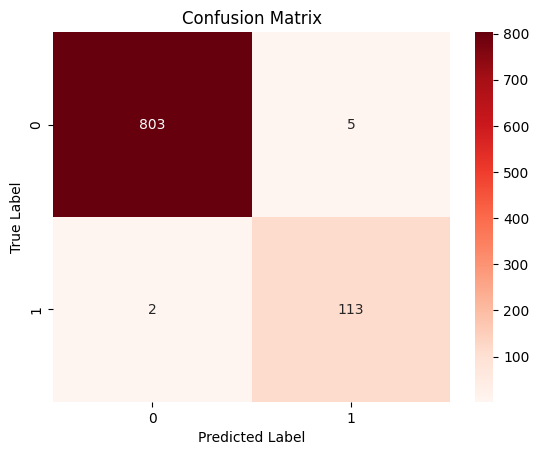

In [349]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [350]:
len(y_pred)

923

In [351]:
y_true= y_test
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,

In [352]:
false_positives = []

for i in range(len(y_pred)):
    if (y_pred[i] == 1 and y_true[i] == 0):
        false_positives.append(i)

false_positive_cases = df.iloc[false_positives]
false_positive_cases


,email,label,has_person_name,untrustworthy_domain
6,lorna.brennan@enron.com,1,0,0
450,percent%50@example.com,0,0,0
556,42.6291.f3-ljwg_jqg8sexzyjnssrr.1@e-mailprogra...,0,0,0
622,lijeji5777@janfab.com,0,1,1
873,eesdas@mailbox.in.ua,0,0,0


In [353]:
np.unique(y_true)

array([0, 1])

In [354]:
unique, counts = np.unique(y, return_counts=True)
y_counts = dict(zip(unique, counts))
print(y_counts)
print("sas")

{0: 4118, 1: 495}
